# Batch analysis 



In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython
import IPython.display
#import shap
from tqdm.notebook import tqdm

tf.random.set_seed(1234)

# Load the dataset from CSV file
og_df = pd.read_csv('data/Structured/all_data.csv')

2023-02-28 08:16:27.562221: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-28 08:16:29.019326: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-28 08:16:29.369318: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/thinlinc/lib64:/opt/thinlinc/lib
2023-02-28 08:16:29.369382: I tensorflow/comp

In [2]:
df = og_df.dropna(axis=1, how='all')
df.drop(['Summa gas/Diesel'], axis=1, inplace=True)

df = df.fillna(method='ffill')
df = df.fillna(method='bfill')
for e in df.columns:
    if df[e].nunique() == 1:
        df = df.drop(e, axis=1)
  
first_column = df.pop('SE1')
df.insert(1, 'SE1', first_column)

test_end = df[df['Date'] == '2018-01-01 23:00:00'].index.values[0]
dates = df.pop('Date')
# df = df.iloc[:,0:5]
print(df.shape)

n_features = df.shape[1]-1
print(n_features)

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df[df.columns])

/tmp/ipykernel_95573/203948321.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['Summa gas/Diesel'], axis=1, inplace=True)
/tmp/ipykernel_95573/203948321.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.insert(1, 'SE1', first_column)


(202878, 470)
469


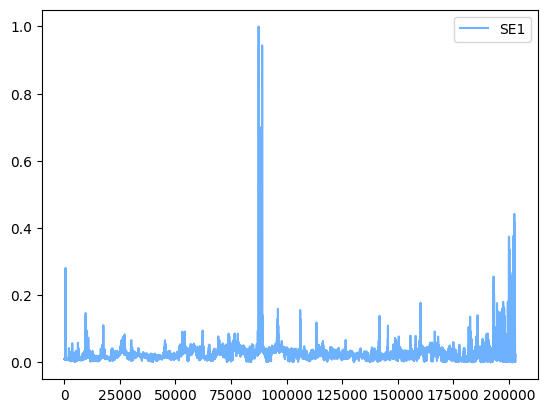

In [3]:
y = df['SE1']

plt.plot(y, color='#6db1ff', label='SE1')
plt.legend()

In [4]:

# Split the dataset into training and testing sets
test_size = int(len(df) * 0.05)
val_size = int(len(df) * 0.1)
val_end = test_end - test_size

train_df = df[:val_end-val_size]
val_df = df[val_end-val_size:val_end]
test_df = df[test_end-test_size:test_end]
train_df = pd.concat([train_df, df[test_end:]])

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(172448, 470)
(20287, 470)
(10143, 470)


In [5]:

train_df = train_df.to_numpy()
# print(train_df.shape)
val_df = val_df.to_numpy()
test_df = test_df.to_numpy()
X_train = np.reshape(train_df[:,1:], (train_df.shape[0], 1, train_df.shape[1]-1))
y_train = train_df[:,0]
print(y_train.shape)
X_val = np.reshape(val_df[:,1:], (val_df.shape[0], 1, val_df.shape[1]-1))
y_val = val_df[:,0]
X_test = np.reshape(test_df[:,1:], (test_df.shape[0], 1, test_df.shape[1]-1))
y_test = test_df[:,0]
# X_train = np.array(train_df.iloc[:,1:])
# y_train = np.array(train_df.iloc[:,0])
# X_val = np.array(val_df.iloc[:,1:])
# y_val = np.array(val_df.iloc[:,0])
# X_test = np.array(test_df.iloc[:,1:])
# y_test = np.array(test_df.iloc[:,0])
# sequence_length = 1
# print(X_train.shape)
# print(y_train.shape)
# print(X_val.shape)
# print(y_val.shape)
# print(X_test.shape)
# print(y_test.shape)
# # Define the sequence length for the LSTM model
# sequence_length = 10

# def create_sequences(df, sequence_length):
#     X = []
#     y = []
#     for i in range(len(df) - sequence_length):
#         X.append(df.iloc[i:i+sequence_length, 1:].values)
#         y.append(df.iloc[i+sequence_length, 0])
#     return np.array(X), np.array(y)


# X_train, y_train = create_sequences(train_df, sequence_length)
# X_val, y_val = create_sequences(val_df, sequence_length)
# X_test, y_test = create_sequences(test_df, sequence_length)
# print(X_train.shape)
# print(X_val.shape)
# print(X_test.shape)

(172448,)


In [6]:
batch_size = 128
print(X_train.shape)
# Calculate the number of samples that are evenly divisible by batch_size
num_samples_train = X_train.shape[0] // batch_size * batch_size
num_samples_val = X_val.shape[0] // batch_size * batch_size
num_samples_test = X_test.shape[0] // batch_size * batch_size

# Reshape the input data to have a shape that is evenly divisible by batch_size
X_train = X_train[:num_samples_train]
y_train = y_train[:num_samples_train]
X_val = X_val[:num_samples_val]
y_val = y_val[:num_samples_val]
X_test = X_test[:num_samples_test]
y_test = y_test[:num_samples_test]
print(X_train.shape)
print(y_train.shape)
# Verify that the new shape is evenly divisible by batch_size
assert X_train.shape[0] % batch_size == 0
assert X_val.shape[0] % batch_size == 0
assert X_test.shape[0] % batch_size == 0

(172448, 1, 469)
(172416, 1, 469)
(172416,)


(172416,)


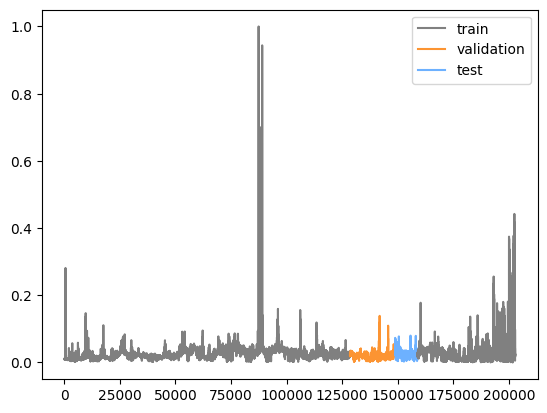

In [7]:
print(y_train.shape)
plt.plot(np.arange(0,val_end-val_size), y_train[0:val_end-val_size], color='grey', label='train')
plt.plot(np.arange(val_end-y_val.shape[0], val_end), y_val, color='#fc9432', label='validation')
plt.plot(np.arange(test_end-y_test.shape[0], test_end), y_test, color='#6db1ff', label='test')
plt.plot(np.arange(test_end,(test_end + y_train[val_end-val_size:].shape[0])), y_train[val_end-val_size:], color='grey')
plt.legend()

In [29]:

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, batch_input_shape=(batch_size, None, n_features), stateful=True),
    tf.keras.layers.Dense(1)
])

model2 = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(None, n_features)),
    tf.keras.layers.Dense(1)
])





In [9]:

class PlotLearning(tf.keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        IPython.display.clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric, color='grey')
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric, color='#6db1ff')
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [25]:

def compile_and_fit(model, X_train, y_train, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])
  model.reset_states()
  # print(model.summary())
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=batch_size, verbose=1)
  return history

# Baseline

## Train Baseline with different batch sizes

In [31]:
# Set batch size to 128 and rerun sample calculations
batch_size = 128
print(X_train.shape)
# Calculate the number of samples that are evenly divisible by batch_size
num_samples_train = X_train.shape[0] // batch_size * batch_size
num_samples_val = X_val.shape[0] // batch_size * batch_size
num_samples_test = X_test.shape[0] // batch_size * batch_size

# Reshape the input data to have a shape that is evenly divisible by batch_size
X_train = X_train[:num_samples_train]
y_train = y_train[:num_samples_train]
X_val = X_val[:num_samples_val]
y_val = y_val[:num_samples_val]
X_test = X_test[:num_samples_test]
y_test = y_test[:num_samples_test]
print(X_train.shape)
print(y_train.shape)
# Verify that the new shape is evenly divisible by batch_size
assert X_train.shape[0] % batch_size == 0
assert X_val.shape[0] % batch_size == 0
assert X_test.shape[0] % batch_size == 0
history3 = compile_and_fit(model, X_train, y_train)
result3 = model.predict(X_val, batch_size=batch_size)


(172416, 1, 469)
(172416, 1, 469)
(172416,)
Epoch 1/10
1347/1347 [==============================] - 9s 6ms/step - loss: 4.2582e-05 - mean_absolute_error: 0.0026 - root_mean_squared_error: 0.0065 - val_loss: 3.1343e-05 - val_mean_absolute_error: 0.0044 - val_root_mean_squared_error: 0.0056
Epoch 2/10
1347/1347 [==============================] - 8s 6ms/step - loss: 8.7759e-06 - mean_absolute_error: 0.0019 - root_mean_squared_error: 0.0030 - val_loss: 3.7923e-05 - val_mean_absolute_error: 0.0048 - val_root_mean_squared_error: 0.0062
Epoch 3/10
1347/1347 [==============================] - 8s 6ms/step - loss: 8.8153e-06 - mean_absolute_error: 0.0020 - root_mean_squared_error: 0.0030 - val_loss: 2.7998e-05 - val_mean_absolute_error: 0.0043 - val_root_mean_squared_error: 0.0053
Epoch 4/10
1347/1347 [==============================] - 7s 5ms/step - loss: 8.8330e-06 - mean_absolute_error: 0.0020 - root_mean_squared_error: 0.0030 - val_loss: 3.5938e-05 - val_mean_absolute_error: 0.0047 - val_root

In [11]:
history = compile_and_fit(model, X_train, y_train)


# Set batch size to 128 and rerun sample calculations
batch_size = 1
print(X_train.shape)
# Calculate the number of samples that are evenly divisible by batch_size
num_samples_train = X_train.shape[0] // batch_size * batch_size
num_samples_val = X_val.shape[0] // batch_size * batch_size
num_samples_test = X_test.shape[0] // batch_size * batch_size

# Reshape the input data to have a shape that is evenly divisible by batch_size
X_train = X_train[:num_samples_train]
y_train = y_train[:num_samples_train]
X_val = X_val[:num_samples_val]
y_val = y_val[:num_samples_val]
X_test = X_test[:num_samples_test]
y_test = y_test[:num_samples_test]
print(X_train.shape)
print(y_train.shape)
# Verify that the new shape is evenly divisible by batch_size
assert X_train.shape[0] % batch_size == 0
assert X_val.shape[0] % batch_size == 0
assert X_test.shape[0] % batch_size == 0

history_128 = compile_and_fit(model2, X_train, y_train)




Epoch 1/3
1347/1347 [==============================] - 10s 6ms/step - loss: 0.0059 - mean_absolute_error: 0.0247 - root_mean_squared_error: 0.0770 - val_loss: 0.0123 - val_mean_absolute_error: 0.0974 - val_root_mean_squared_error: 0.1110
Epoch 2/3
1347/1347 [==============================] - 7s 5ms/step - loss: 1.2339e-04 - mean_absolute_error: 0.0067 - root_mean_squared_error: 0.0111 - val_loss: 0.0119 - val_mean_absolute_error: 0.0965 - val_root_mean_squared_error: 0.1092
Epoch 3/3
1347/1347 [==============================] - 7s 5ms/step - loss: 6.1363e-05 - mean_absolute_error: 0.0047 - root_mean_squared_error: 0.0078 - val_loss: 0.0053 - val_mean_absolute_error: 0.0634 - val_root_mean_squared_error: 0.0730
(172416, 1, 469)
(172416, 1, 469)
(172416,)
Epoch 1/3
172416/172416 [==============================] - 620s 4ms/step - loss: 1.3968e-04 - mean_absolute_error: 0.0060 - root_mean_squared_error: 0.0118 - val_loss: 1.3616e-04 - val_mean_absolute_error: 0.0098 - val_root_mean_squared

## Baseline result/residuals

In [23]:
# Set batch size to 1 and rerun sample calculations
batch_size = 1

# Calculate the number of samples that are evenly divisible by batch_size
num_samples_train = X_train.shape[0] // batch_size * batch_size
num_samples_val = X_val.shape[0] // batch_size * batch_size
num_samples_test = X_test.shape[0] // batch_size * batch_size

# Reshape the input data to have a shape that is evenly divisible by batch_size
X_train = X_train[:num_samples_train]
y_train = y_train[:num_samples_train]
X_val = X_val[:num_samples_val]
y_val = y_val[:num_samples_val]
X_test = X_test[:num_samples_test]
y_test = y_test[:num_samples_test]

# Verify that the new shape is evenly divisible by batch_size
assert X_train.shape[0] % batch_size == 0
assert X_val.shape[0] % batch_size == 0
assert X_test.shape[0] % batch_size == 0
result = model2.predict(X_val, batch_size=batch_size)


# Set batch size to 128 and rerun sample calculations
batch_size = 128

# Calculate the number of samples that are evenly divisible by batch_size
num_samples_train = X_train.shape[0] // batch_size * batch_size
num_samples_val = X_val.shape[0] // batch_size * batch_size
num_samples_test = X_test.shape[0] // batch_size * batch_size

# Reshape the input data to have a shape that is evenly divisible by batch_size
X_train = X_train[:num_samples_train]
y_train = y_train[:num_samples_train]
X_val = X_val[:num_samples_val]
y_val = y_val[:num_samples_val]
X_test = X_test[:num_samples_test]
y_test = y_test[:num_samples_test]
# Verify that the new shape is evenly divisible by batch_size
assert X_train.shape[0] % batch_size == 0
assert X_val.shape[0] % batch_size == 0
assert X_test.shape[0] % batch_size == 0
result2 = model.predict(X_val, batch_size=batch_size)

158/158 [==============================] - 1s 3ms/step


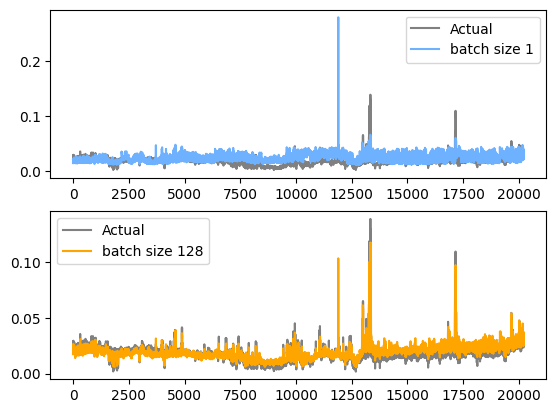

In [35]:
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(y_val, label='Actual', color='grey')
ax1.plot(result, label='batch size 1', color='#6db1ff')
#residuals = abs(np.subtract(np.array(result[:,0]), np.array(y_test)))
# residuals = y_test - result
ax1.legend()
ax2.plot(y_val, label='Actual', color='grey')
ax2.plot(result3, label='batch size 128', color='orange')
ax2.legend()
